In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#import antoher libraries 
import seaborn as sns 
import matplotlib.pyplot as plt

from tqdm import tqdm 

#machine learning libraries 

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix 
from sklearn.ensemble import VotingClassifier

#classifier libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings 
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


**Load the dataset into a variable**

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")
subm = pd.read_csv("/kaggle/input/playground-series-s4e3/sample_submission.csv")

df_train.head(10)

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
5,5,1009,1033,899231,899307,409,22,26,47513,86,...,0.5909,-0.1890,0.8749,0,0,0,0,0,0,1
6,6,596,607,739072,7390760,204,21,21,22478,89,...,0.3158,-0.1497,0.5212,0,0,0,0,0,1,0
7,7,1673,1687,294065,294091,571,38,57,53142,77,...,0.0357,-0.2661,0.9408,1,0,0,0,0,0,0
8,8,507,521,203252,203261,101,25,12,12530,124,...,-0.6667,0.0305,0.3601,0,0,0,0,0,0,0
9,9,893,907,1341292,1341296,54,6,15,7052,87,...,0.4667,-0.1228,0.1400,0,0,0,0,0,1,0


**Reset the index column and replace with id column**

In [3]:
#for train dan test dataset

df_train = df_train.set_index('id').reset_index(drop=True)
df_test = df_test.set_index('id').reset_index(drop=True)

df_train.head(10)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
5,1009,1033,899231,899307,409,22,26,47513,86,118,...,0.5909,-0.1890,0.8749,0,0,0,0,0,0,1
6,596,607,739072,7390760,204,21,21,22478,89,127,...,0.3158,-0.1497,0.5212,0,0,0,0,0,1,0
7,1673,1687,294065,294091,571,38,57,53142,77,110,...,0.0357,-0.2661,0.9408,1,0,0,0,0,0,0
8,507,521,203252,203261,101,25,12,12530,124,140,...,-0.6667,0.0305,0.3601,0,0,0,0,0,0,0
9,893,907,1341292,1341296,54,6,15,7052,87,133,...,0.4667,-0.1228,0.1400,0,0,0,0,0,1,0


In [4]:
print ("Train dataset:", df_train.shape)
print ("Test dataset:", df_test.shape) 

Train dataset: (19219, 34)
Test dataset: (12814, 27)


**Set the Target**

In [5]:
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps','Other_Faults']

**Checking the Dataset**

In [6]:
#checking the train dataset if there's missing value 
df_train.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [7]:
#checking the test dataset if there's missing value 
df_test.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

**Data Exploration**

Text(0, 0.5, 'Columns')

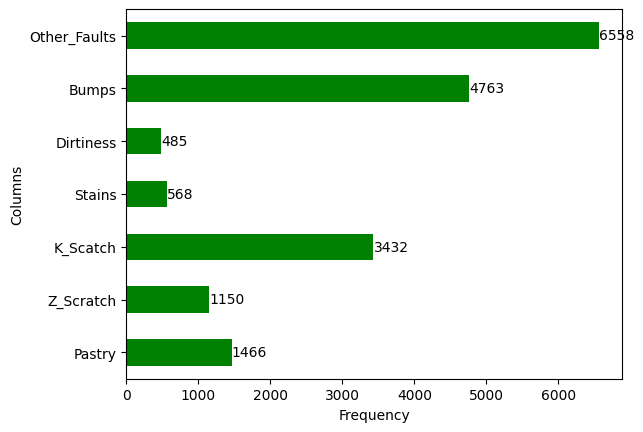

In [8]:
ax = df_train[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps','Other_Faults']].sum(axis= 0).plot(kind= 'barh', color='green')
ax.bar_label(ax.containers[0], label_type= 'edge')
plt.xlabel('Frequency')
plt.ylabel('Columns')

from above chart, the data is imbalanced.

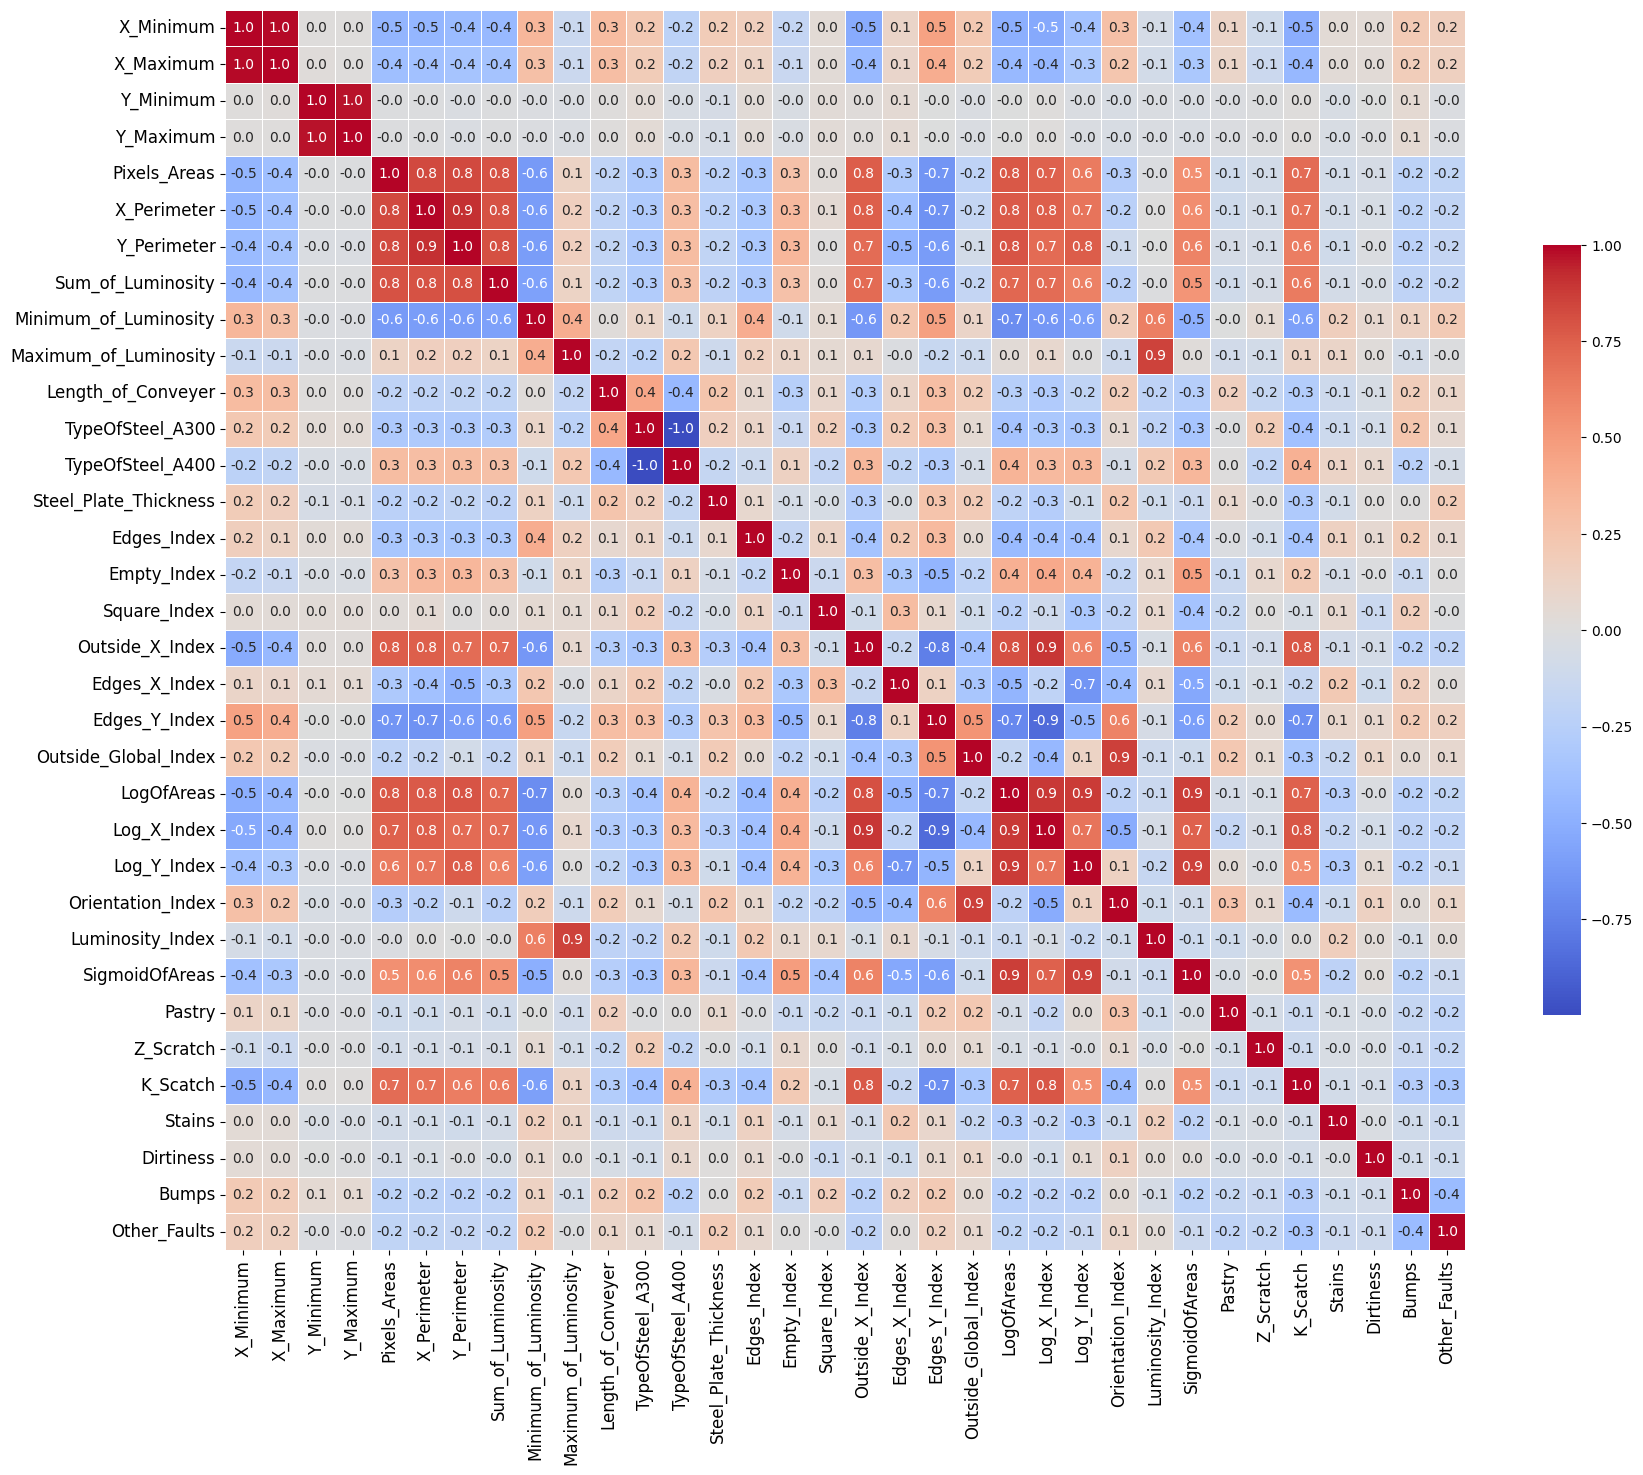

In [9]:
#make the correlation matrix to know more about the data
correlation = df_train.corr()
f, axs = plt.subplots(figsize= (20,20))

sns.heatmap(correlation, annot= True, fmt= ".1f", linewidths= 0.5, square= True, cmap= 'coolwarm', cbar_kws={"shrink": .5}, ax= axs)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

plt.show()

**Split the training dataset**

In [10]:
X, y = df_train.drop(target, axis=1), np.argmax(df_train[target], axis=1)
X.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [11]:
def auc_score(estimator, X, y):
    y_prob= estimator.predict_proba(X)
    return roc_auc_score (y, y_prob, multi_class= "ovr")

**Classifier**

In [12]:
xgb= XGBClassifier(device= 'cuda')
lgbm= LGBMClassifier(verbose= 1, device= 'cpu')
cat= CatBoostClassifier(verbose= 0, task_type= 'CPU')
voting= VotingClassifier(estimators= [('xgb', xgb), ('lgbm', lgbm), ('cat', cat)], voting= 'soft')

scores= cross_val_score(voting, X, y, scoring= auc_score, cv= 5)
print(f'ROC AUC: {scores.mean()}')

voting.fit(X,y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5201
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 27
[LightGBM] [Info] Start training from score -2.130068
[LightGBM] [Info] Start training from score -2.816124
[LightGBM] [Info] Start training from score -1.722962
[LightGBM] [Info] Start training from score -3.522401
[LightGBM] [Info] Start training from score -3.679493
[LightGBM] [Info] Start training from score -1.395376
[LightGBM] [Info] Start training from score -1.077949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5204
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 27
[LightGBM] [Info] Start training from score 

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgbm', LGBMClassifier(device='cpu', verbose=1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7a4790e437c0>)],
                 voting='soft')

**Explore the training result**

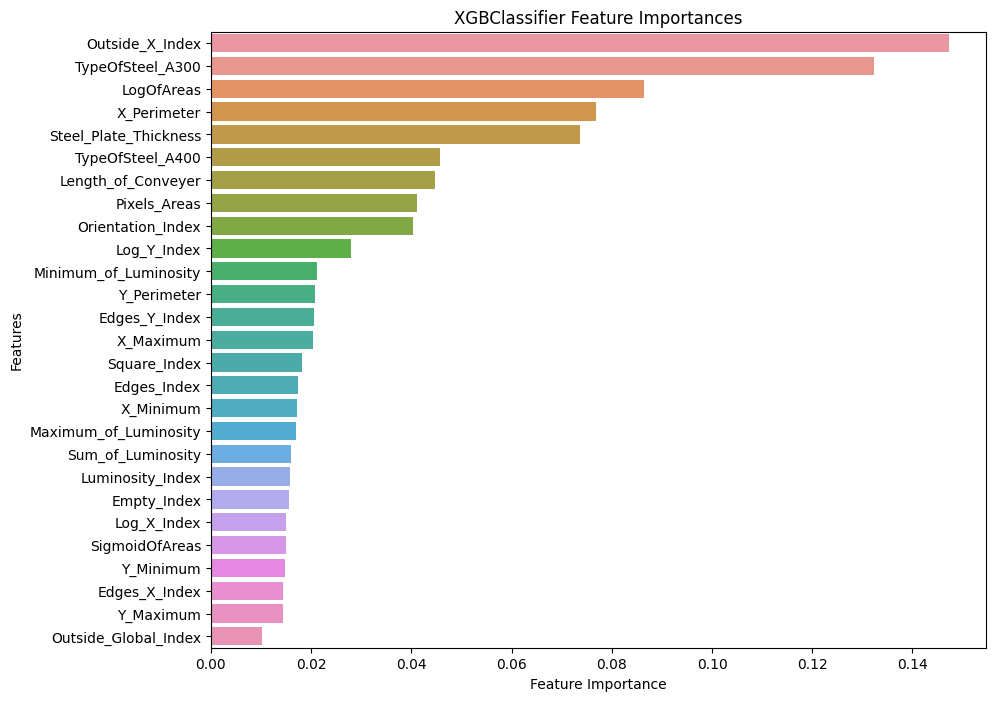

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5219
[LightGBM] [Info] Number of data points in the train set: 19219, number of used features: 27
[LightGBM] [Info] Start training from score -2.129971
[LightGBM] [Info] Start training from score -2.816137
[LightGBM] [Info] Start training from score -1.723048
[LightGBM] [Info] Start training from score -3.521533
[LightGBM] [Info] Start training from score -3.679506
[LightGBM] [Info] Start training from score -1.395442
[LightGBM] [Info] Start training from score -1.077962


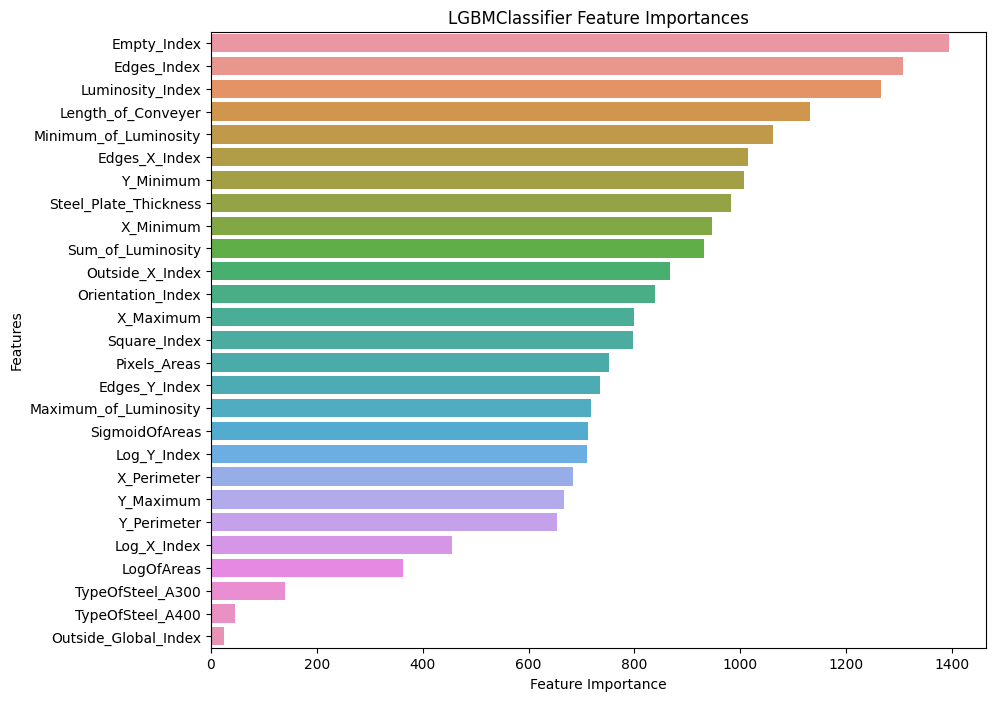

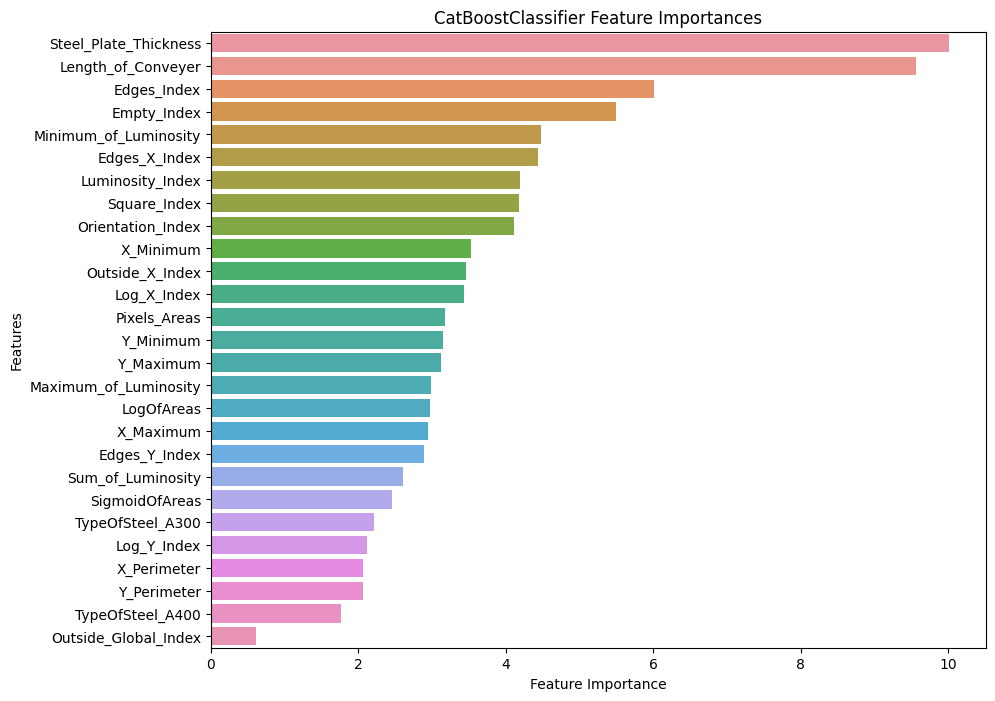

In [13]:
model_names= ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
model_list= [xgb, lgbm, cat]

for i, (name,model) in enumerate(zip(model_names, model_list)):
    
    model.fit(X,y)
    importances= model.feature_importances_
    
    df= pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    df= df.sort_values('Importance', ascending= False)
    
    plt.figure(figsize= (10,8))
    sns.barplot(x= 'Importance', y= 'Feature', data= df)
    
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'{name} Feature Importances')
    
    plt.show()

In [14]:
subm.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,19222,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,19223,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [15]:
subm[target] = voting.predict_proba(df_test)
subm.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.481409,0.000679,0.001157,0.000007,0.017865,0.142881,0.356002
1,19220,0.211480,0.014031,0.004746,0.000041,0.147008,0.139927,0.482767
2,19221,0.094579,0.035687,0.036195,0.000102,0.002154,0.348529,0.482754
3,19222,0.130923,0.000322,0.000121,0.000204,0.004142,0.435971,0.428318
4,19223,0.038007,0.000196,0.000247,0.000711,0.001930,0.686672,0.272238


In [16]:
subm.to_csv('submission.csv', index=False)